## imports 

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense,LSTM,Dropout,Activation,BatchNormalization,Conv1D,MaxPooling1D,Flatten
from sklearn.metrics import mean_squared_error


In [42]:
import time

start_time = time.perf_counter()

### Load Dataset
##### the following dataset contains Iran stock index price since **2014(1393)** to **2019(1397)**

In [43]:
# df = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\1393-1397.csv")
df = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\1393--1403.csv")
df

,name,dateissue,Value
0,????,14021228,2195092.3
1,????,14021227,2160406.5
2,????,14021226,2148494.0
3,????,14021223,2150035.3
4,????,14021222,2163501.0
...,...,...,...
2408,????,13930111,78741.3
2409,????,13930110,78469.2
2410,????,13930109,78239.7
2411,????,13930106,78619.4


In [166]:
df = df.iloc[::-1] 
df

,name,dateissue,Value
2412,????,13930105,79013.5
2411,????,13930106,78619.4
2410,????,13930109,78239.7
2409,????,13930110,78469.2
2408,????,13930111,78741.3
...,...,...,...
4,????,14021222,2163501.0
3,????,14021223,2150035.3
2,????,14021226,2148494.0
1,????,14021227,2160406.5


In [167]:
df = df[["dateissue" , "Value"]] # delete شاخص column

In [168]:
color_pal = sns.color_palette()

In [169]:
df1 = df[df["dateissue"] > 13970211] #barjam date
df2 = df[df["dateissue"] <= 13970211]
df2

,dateissue,Value
2412,13930105,79013.5
2411,13930106,78619.4
2410,13930109,78239.7
2409,13930110,78469.2
2408,13930111,78741.3
...,...,...
1423,13970205,94796.1
1422,13970208,94284.4
1421,13970209,93805.5
1420,13970210,93586.9


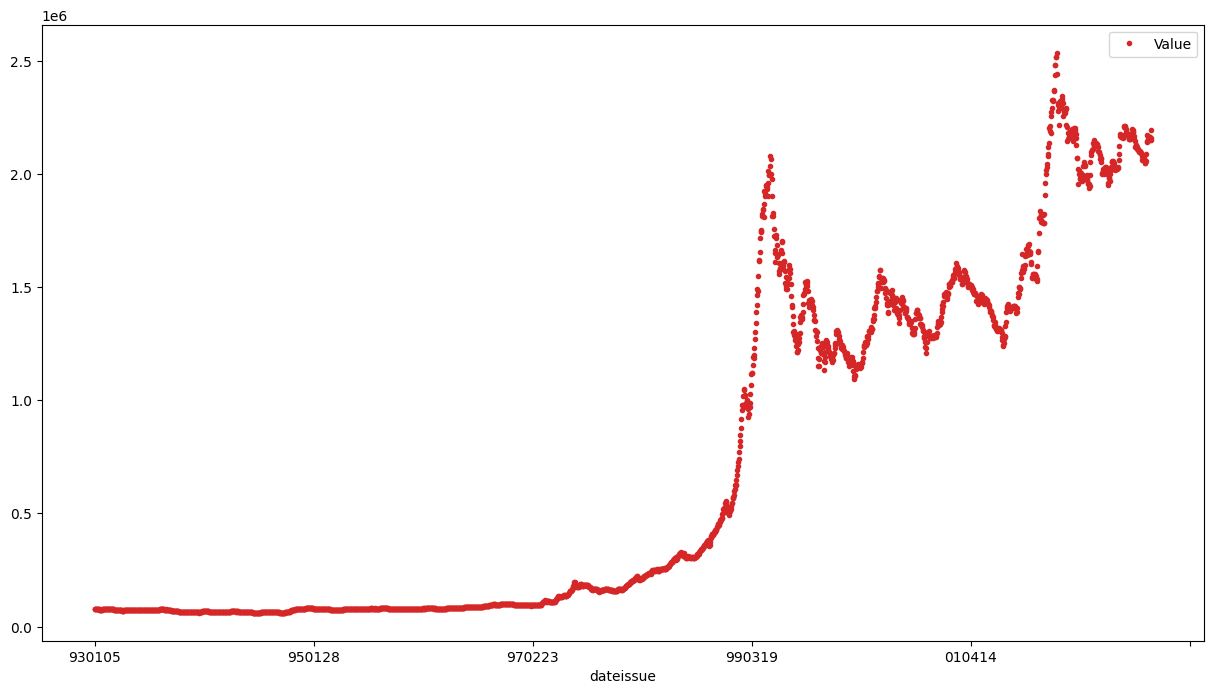

In [170]:
df['dateissue'] = df['dateissue'].apply(lambda x: str(x)[-6:])
df.plot( x="dateissue", y="Value", style='.', figsize=(15,8), color=color_pal[3])
clear_output()
plt.show()

In [171]:
df1['dateissue'] = df1['dateissue'].apply(lambda x: str(x)[-6:])
df2['dateissue'] = df2['dateissue'].apply(lambda x: str(x)[-6:])
clear_output()

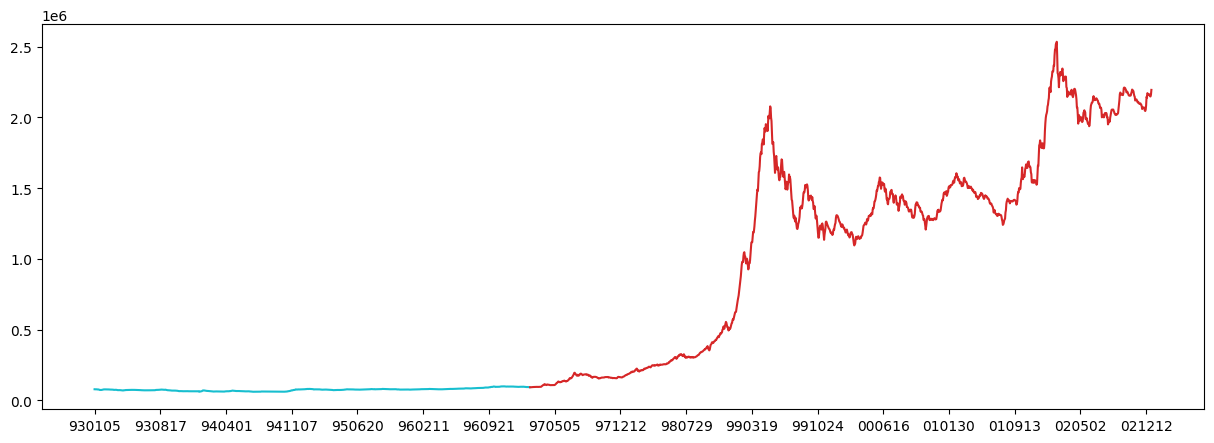

In [172]:
plt.plot(df2["dateissue"], df2["Value"], color=color_pal[9])
plt.plot(df1["dateissue"], df1["Value"], color=color_pal[3]) # after barjam (red)
plt.xticks(np.arange(0, len(df), step=150))
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [173]:
df.shape

(2413, 2)

In [174]:
df.index = df.pop("dateissue")
df

,Value
dateissue,
930105,79013.5
930106,78619.4
930109,78239.7
930110,78469.2
930111,78741.3
...,...
021222,2163501.0
021223,2150035.3
021226,2148494.0


### preprocessing

In [175]:
# scaler = MinMaxScaler(feature_range=(0,1))
# dataset = scaler.fit_transform(dataset)
# dataset

# test_dataset = [i for i in dataset if i not in train_dataset]
# test_dataset

# df['Value'] = df['Value'] / 100000

df_mean = df['Value'].mean()
df['Value'] = df['Value'] / df_mean
clear_output()
df

,Value
dateissue,
930105,0.112551
930106,0.111990
930109,0.111449
930110,0.111776
930111,0.112163
...,...
021222,3.081804
021223,3.062623
021226,3.060427


In [176]:
dataset = df.values

### split train and test datasets  

In [177]:
train_count = math.ceil(len(dataset) * 0.80) # find 80% of our dataset
print(train_count)
print(len(dataset)-train_count)
print(dataset.shape)

1931
482
(2413, 1)


In [178]:
train_dataset = dataset[0:train_count]
train_dataset = np.array(train_dataset)
train_dataset

array([[0.11255096],
       [0.11198958],
       [0.11144872],
       ...,
       [1.90217997],
       [1.90132601],
       [1.90481065]])

##### *we create a sequence(to make an iteratin on the dataset) for every data in the dataframe to use it for lstm and rnn  models in the future.*

In [179]:
x_train = []
y_train = []

for i in range(10,train_count):
    x_train.append(train_dataset[i-10:i, 0])
    y_train.append(train_dataset[i,0])
    if i<=10 : #we can get the first round of the train dataset which we created
        print(x_train)
        print(y_train)

[array([0.11255096, 0.11198958, 0.11144872, 0.11177563, 0.11216323,
       0.11188745, 0.11058693, 0.1102791 , 0.11084732, 0.11028665])]
[0.10897316436782095]


In [180]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1921, 10)

In [181]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1921, 10, 1)

### create models: 
1. LSTM
2. CNN

In [182]:
lstm_model = Sequential()
nn_model = Sequential()

In [183]:
# model = Sequential([
#     layers.LSTM(50, return_sequences=True, input_shape=(10,1)),
#     layers.LSTM(50, return_sequences=False),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(16, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(1, activation='relu'),
# ])

lstm_model.add(LSTM(50, input_shape = (10,1), return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
# lstm_model.add(Activation("linear"))

# model.add(LSTM(50, return_sequences=True, input_shape=(10,1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(64))
# model.add(Dense(32))
# model.add(Dense(8))
# model.add(Dense(1))

In [184]:
nn_model.add(Dense(128,input_shape=(10,1)))
nn_model.add(Conv1D(filters = 112, kernel_size= 1,padding='valid', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=2, padding='valid'))
nn_model.add(Conv1D(filters = 64,kernel_size = 1,padding='valid', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=1, padding='valid'))
nn_model.add(Dropout(0.2))
nn_model.add(Flatten())
nn_model.add(Dense(100, activation="linear"))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1))

In [185]:
keras.utils.plot_model(lstm_model) 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [186]:
lstm_model.compile(loss="mse", optimizer="adam", metrics=['mae', 'accuracy'])
nn_model.compile(loss="mse", optimizer="adam", metrics=['mae', 'accuracy'])

In [187]:
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout_16 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 256)               314368    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [188]:
nn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 10, 128)           256       
                                                                 
 conv1d_8 (Conv1D)           (None, 10, 112)           14448     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 5, 112)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 5, 64)             7232      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 5, 64)            

### fit models

In [189]:
lstm_history = lstm_model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
193/193 [==============================] - 7s 14ms/step - loss: 0.0282 - mae: 0.0722 - accuracy: 0.0000e+00
Epoch 2/10
193/193 [==============================] - 3s 13ms/step - loss: 0.0105 - mae: 0.0542 - accuracy: 0.0000e+00
Epoch 3/10
193/193 [==============================] - 2s 13ms/step - loss: 0.0084 - mae: 0.0461 - accuracy: 0.0000e+00
Epoch 4/10
193/193 [==============================] - 3s 13ms/step - loss: 0.0070 - mae: 0.0430 - accuracy: 0.0000e+00
Epoch 5/10
193/193 [==============================] - 2s 13ms/step - loss: 0.0070 - mae: 0.0430 - accuracy: 0.0000e+00
Epoch 6/10
193/193 [==============================] - 3s 13ms/step - loss: 0.0069 - mae: 0.0421 - accuracy: 0.0000e+00
Epoch 7/10
193/193 [==============================] - 2s 13ms/step - loss: 0.0065 - mae: 0.0402 - accuracy: 0.0000e+00
Epoch 8/10
193/193 [==============================] - 2s 13ms/step - loss: 0.0066 - mae: 0.0414 - accuracy: 0.0000e+00
Epoch 9/10
193/193 [============================

In [190]:
nn_history = nn_model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
193/193 [==============================] - 2s 2ms/step - loss: 0.0379 - mae: 0.0879 - accuracy: 0.0000e+00
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 0.0160 - mae: 0.0644 - accuracy: 0.0000e+00
Epoch 3/10
193/193 [==============================] - 1s 3ms/step - loss: 0.0137 - mae: 0.0612 - accuracy: 0.0000e+00
Epoch 4/10
193/193 [==============================] - 0s 3ms/step - loss: 0.0139 - mae: 0.0629 - accuracy: 0.0000e+00
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 0.0129 - mae: 0.0625 - accuracy: 0.0000e+00
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 0.0104 - mae: 0.0558 - accuracy: 0.0000e+00
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 0.0104 - mae: 0.0582 - accuracy: 0.0000e+00
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 0.0121 - mae: 0.0610 - accuracy: 0.0000e+00
Epoch 9/10
193/193 [==============================] - 1s

### create test array

In [191]:
test_dataset = dataset[train_count-10:,:]
x_test = []
y_test = dataset[train_count:,:]

for i in range(10,len(test_dataset)):
    x_test.append(test_dataset[i-10:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))
x_test.shape

(482, 10, 1)

In [192]:
lstm_predicts = lstm_model.predict(x_test)
print(f"lstm shape = {lstm_predicts.shape}")

nn_predicts = nn_model.predict(x_test)
print(f"cnn shape = {lstm_predicts.shape}")

16/16 [==============================] - 1s 8ms/step
lstm shape = (482, 1)
16/16 [==============================] - 0s 1ms/step
cnn shape = (482, 1)


In [193]:
print(nn_history.history.keys())
print(lstm_history.history.keys())

dict_keys(['loss', 'mae', 'accuracy'])
dict_keys(['loss', 'mae', 'accuracy'])


In [194]:
h1 = lstm_history.history
lstm_loss = h1["loss"]
h1 = nn_history.history
cnn_loss = h1["loss"]
epochs = [i for i in range(1,len(h1["loss"]) + 1)]

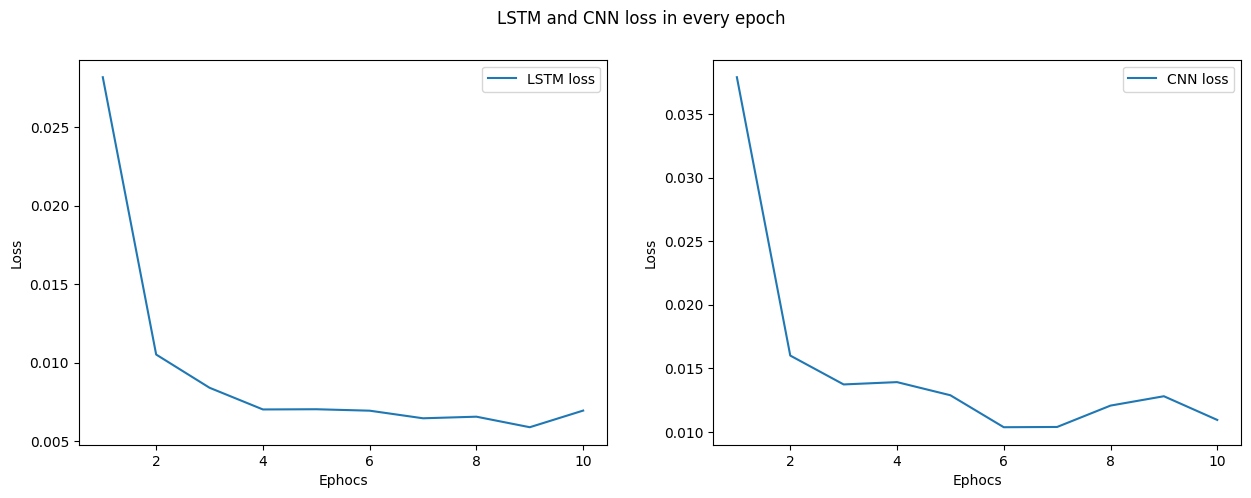

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('LSTM and CNN loss in every epoch')
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(epochs, lstm_loss, label = "LSTM loss")
ax1.set(xlabel="Ephocs", ylabel="Loss")
ax1.legend()

ax2.plot(epochs, cnn_loss, label= "CNN loss")
ax2.set(xlabel="Ephocs", ylabel="Loss")
ax2.legend()


### Model Validation

In [196]:
print(f"Lstm model Last epoch loss  = {lstm_history.history['loss'][-1]}")
print(f"CNN model Last epoch loss  = {nn_history.history['loss'][-1]}")

Lstm model Last ephoc loss  = 0.006949559319764376
CNN model Last ephoc loss  = 0.010928303003311157


In [197]:
lstm_test_loss, lstm_test_acc, _ = lstm_model.evaluate(x_test, y_test) 

16/16 [==============================] - 1s 9ms/step - loss: 0.0619 - mae: 0.1995 - accuracy: 0.0000e+00


In [198]:
cnn_test_loss, cnn_test_acc, _ = nn_model.evaluate(x_test, y_test) 

16/16 [==============================] - 1s 2ms/step - loss: 0.1094 - mae: 0.3115 - accuracy: 0.0000e+00


In [199]:
data = {'LSTM': [lstm_test_acc,math.sqrt(mean_squared_error(y_test, lstm_predicts)),mean_squared_error(y_test, lstm_predicts)],
        'CNN': [cnn_test_acc, math.sqrt(mean_squared_error(y_test, nn_predicts)),mean_squared_error(y_test, nn_predicts)]}
errors = pd.DataFrame(data, index=['acc',
                               'RSME',
                               'MSE'])
errors

,LSTM,CNN
acc,0.199477,0.311544
RSME,0.248795,0.330780
MSE,0.061899,0.109416


In [200]:
train = df[:train_count] * df_mean
validation = df[train_count:] * df_mean
validation[['predictions(lstm)']] = lstm_predicts * df_mean
validation[['predictions(nn)']] = nn_predicts * df_mean
clear_output()
validation

,Value,predictions(lstm),predictions(nn)
dateissue,,,
001225,1345018.2,1327884.375,1208186.500
001228,1367250.3,1329965.875,1211924.500
010106,1390859.7,1334357.250,1217538.375
010107,1403617.9,1341612.125,1224423.375
010108,1418651.9,1350460.375,1230870.750
...,...,...,...
021222,2163501.0,1919730.750,1869578.500
021223,2150035.3,1922576.375,1872245.875
021226,2148494.0,1922740.500,1879092.000


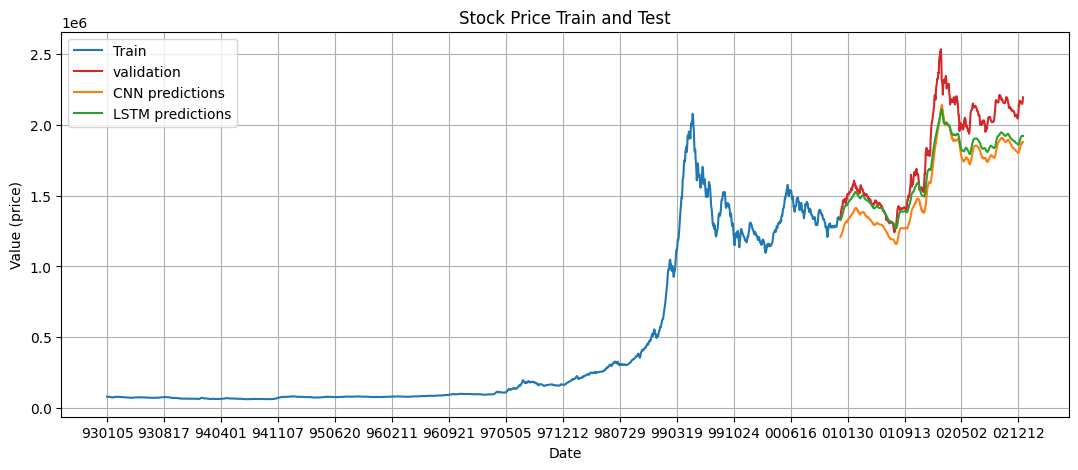

In [201]:
plt.figure(figsize=(12,5))
plt.plot(train["Value"], color=color_pal[0])
plt.plot(validation[["Value"]], color =color_pal[3])
plt.plot(validation[["predictions(nn)"]], color=color_pal[1])
plt.plot(validation[["predictions(lstm)"]], color=color_pal[2])
plt.xticks(np.arange(0, len(df), step=150))
plt.title("Stock Price Train and Test")
plt.xlabel("Date")
plt.ylabel("Value (price)")
plt.legend(['Train','validation', 'CNN predictions', 'LSTM predictions'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(13, 5)
plt.grid()
plt.savefig('models-validation-(93-03)')
plt.show()

In [202]:
end_time = time.perf_counter()
run_time = end_time - start_time
print(f'Run time (s) : {str(run_time)[0:3]}') #calculate run time

'42.'

## OK
now let's add some more parameteres and see if the result is getting better or not


we know that a lot of stocks can impact the main Stock Price, so...

In [59]:
import pandas as pd
original_df = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\1393--1403.csv")
df01 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\30-bcoms.csv")
df02 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\bazar-aval.csv")
df03 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\car industry.csv")
df04 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\fara-boors.csv")
df05 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\ham-vazn-sh.csv")
df06 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\ham-vazn.csv")
df07 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\oil.csv")
df08 = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\total-fara-boors.csv")

In [60]:
print(original_df.shape == df01.shape == df02.shape == df03.shape == df05.shape == df06.shape == df07.shape)
print(df01.shape)
print(df04.shape)
print(df08.shape)

True
(2413, 3)
(2411, 3)
(2411, 3)


In [61]:
list1 = [x for x in df01.iloc[:,1]]
list2 = [x for x in df08.iloc[:,1]]

for i in list1:
    if i not in list2:
        print(i)


14021219
14010107


In [62]:
original_df = original_df[~ original_df.dateissue.isin([14021219,14010107])] 
df01 = df01[~ df01.dateissue.isin([14021219,14010107])] 
df02 = df02[~ df02.dateissue.isin([14021219,14010107])] 
df03 = df03[~ df03.dateissue.isin([14021219,14010107])] 
df05 = df05[~ df05.dateissue.isin([14021219,14010107])] 
df06 = df06[~ df06.dateissue.isin([14021219,14010107])] 
df07 = df07[~ df07.dateissue.isin([14021219,14010107])] 

df01.shape

(2411, 3)

In [79]:
new_df = pd.DataFrame()
new_df['30-big-company'] = df01.Value.values
new_df['bazar-aval'] = df02.Value.values
new_df['car-industry'] = df03.Value.values
new_df['fara-boors'] = df04.Value.values
new_df['ham-vazn-sh'] = df05.Value.values
new_df['ham-vazn'] = df06.Value.values
new_df['oil'] = df07.Value.values
new_df['total-fara-boors'] = df08.Value.values
new_df['original-stock'] = original_df.Value.values
new_df

,30-big-company,bazar-aval,car-industry,fara-boors,ham-vazn-sh,ham-vazn,oil,total-fara-boors,original-stock
0,136636.0,1712220.0,338784.0,25367.2,742576.0,417319.0,10326870.6,25367.2,2195092.3
1,133500.0,1675500.0,333306.0,25068.2,733780.0,412376.0,10057724.0,25068.2,2160406.5
2,132211.0,1661410.0,329172.0,24857.2,730215.0,410590.0,10037313.4,24857.2,2148494.0
3,132041.0,1660480.0,333691.0,24852.0,732031.0,411665.0,10093500.0,24852.0,2150035.3
4,133131.0,1671980.0,339862.0,24976.4,735945.0,413933.0,10268082.1,24976.4,2163501.0
...,...,...,...,...,...,...,...,...,...
2406,3733.7,58534.5,11561.0,781.3,10141.0,10141.0,334467.0,781.3,78741.3
2407,3729.0,58455.3,11329.4,772.1,10055.5,10055.5,330095.0,772.1,78469.2
2408,3725.2,58339.8,11132.5,760.4,9984.4,9984.4,326336.0,760.4,78239.7
2409,3742.0,58490.4,10979.7,763.6,9998.3,9998.3,331090.0,763.6,78619.4


In [80]:
new_df.index = original_df.dateissue
new_df.index = new_df.index.map(lambda x: str(x)[-6:])
new_df = new_df[::-1]
new_df.head()